# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [2]:
from scipy.cluster.hierarchy import dendrogram
from itertools import permutations

In [3]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data.csv')
label = pd.read_csv('data/labels.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. Perform basic data inspection or EDA on the pandas dataframe.
- How many observations?
- How many features?
- If we were to train a "supervised" learning model, how would you deal with such large feature dimension? 
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm?
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.)

- How many observations?
    - 801
- How many features?
    - 20531
- If we were to train a "supervised" learning model, how would you deal with such large feature dimension? 
    - we can use PCA to reduce the dimensionalty of the dataset. 
    - random feature selection with Random Forests calssificiation
    - remove highly correlated features
    - Forward feature selection
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
    - KNN. Uses distance formulas to determine classifications. With to many features, 
    - SVM - uses a distance formulas to help determine 
    - Linear Regression
    
- How it would impact performance or runtime of an unsupervised learning algorithm?
     - The more dimensions the data has, the longer it will take for certain clustering algorithms to converge. 
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.)
    - 

In [4]:
label['Class'].unique()

array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

In [5]:
label.head()

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA


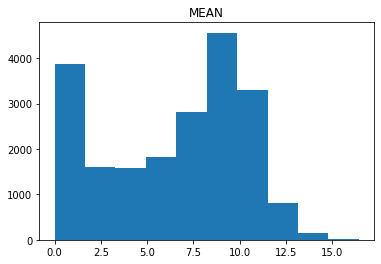

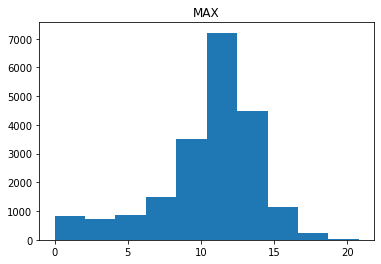

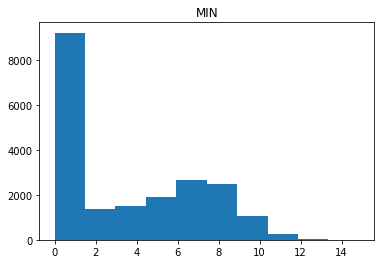

In [6]:
plt.hist(data.mean())
plt.title('MEAN')
plt.show()
plt.title('MAX')
plt.hist(data.max())
plt.show()
plt.title('MIN')
plt.hist(data.min())
plt.show()

In [7]:
data.min()

gene_0        0.000000
gene_1        0.000000
gene_2        0.000000
gene_3        5.009284
gene_4        8.435999
                ...   
gene_20526    9.045255
gene_20527    7.530141
gene_20528    7.864533
gene_20529    0.593975
gene_20530    0.000000
Length: 20531, dtype: float64

In [8]:
print(data.head())
print(data.shape)
print(label)
print(label.shape)

   gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   

     gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
3  0.434882     0.0     0.0  ...    6.076566    8.792959   10.141520   
4  0.360982     0.0     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  \
0    7.220030    9.119813   12.003135    9.650743    8.92

### B. Build a hierarchical clustering model 
Let's build a model using hierarchical clustering. Hierarchical clustering module is available from  `sklearn.cluster.AgglomerativeClustering`. You can choose linkage type and metric. Please check its documentation for more details.

#### a) Number of clusters vs distance threshold
Ofterntimes hierarchical clustering does not need to know the number of clusters in advance. Instead, one needs to choose threshold distance/similarity to cut the dendrogram later.  The `AgglomerativeClustering` module lets you specify either the number of clusters (`n_clusters`) or the threshold (`distance_threshold`). Based on our data, which should we choose to set to which value and why?

#### b) Guess which metric?
Can you guess which metric to use (distance-based vs. similarity-based) and why? Share your thoughts with the class.

#### c) Build a model
Build a model using n_clusters=5 option. Choose any metric and linkage type at first. Display the clustering result labels (you can just print out the result). Do not change the variable (model) name.

In [9]:
model= AgglomerativeClustering(n_clusters=5, linkage='complete')
model.fit(data)


AgglomerativeClustering(linkage='complete', n_clusters=5)

In [10]:
y_pred = model.labels_
print(y_pred)

[4 3 1 4 1 4 0 4 1 4 1 0 4 2 1 1 3 0 0 4 1 0 3 1 0 3 2 1 1 1 1 1 0 3 4 1 0
 3 1 3 0 4 4 0 0 1 4 2 1 3 1 3 1 4 2 1 1 3 0 1 3 0 1 3 4 2 1 4 0 1 0 1 1 3
 1 3 1 0 4 2 1 4 1 1 4 4 1 1 0 1 4 4 1 3 1 4 2 1 4 1 1 0 1 0 3 0 3 3 3 3 4
 1 3 4 1 0 0 0 1 1 3 0 3 1 4 4 4 1 0 1 2 1 2 1 1 0 3 1 0 2 1 4 1 0 3 2 4 1
 3 3 3 3 1 1 3 1 1 4 4 3 4 3 0 1 4 3 2 0 3 1 0 3 1 3 1 1 1 4 1 0 2 0 1 4 4
 4 3 3 1 3 3 0 3 4 3 1 3 1 3 3 1 0 0 0 0 4 2 4 1 3 3 1 4 1 4 1 1 1 3 1 0 3
 0 0 3 1 0 4 1 3 3 4 2 2 0 4 0 3 1 0 0 3 4 4 3 3 0 1 1 2 1 4 3 1 4 0 4 4 4
 1 3 2 3 2 3 4 3 1 1 0 0 1 2 4 0 4 1 1 0 1 1 1 2 3 3 1 1 1 0 0 0 0 3 1 1 0
 1 1 3 4 1 1 2 3 4 1 1 1 2 1 4 1 2 3 3 4 0 1 0 0 3 3 0 1 1 1 3 0 1 1 4 3 0
 1 3 4 0 1 4 2 1 1 1 3 3 3 1 1 4 3 1 0 1 2 3 3 1 0 1 1 1 2 3 2 0 4 0 1 1 0
 3 2 4 3 4 3 0 4 1 2 0 0 2 2 4 1 3 3 0 3 4 1 1 1 3 3 0 3 3 0 2 4 1 3 4 1 2
 1 3 1 1 4 1 4 2 1 3 1 1 3 1 1 1 0 3 4 1 4 0 1 0 2 1 4 3 0 1 1 0 1 3 3 1 4
 2 1 0 3 4 1 4 1 1 1 1 0 3 1 0 1 1 3 3 0 3 4 2 1 0 0 1 4 0 3 3 3 1 4 4 1 4
 3 0 4 1 3 4 3 1 1 2 3 0 

#### d) Label permuation
In clustering, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. Write a function below to find best matching label ordering based on the accuracy. Do not change the variable names.

In [11]:
import itertools

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3(KIRK), 4(COAD), 1(LAUD), 2(BRCA), 0(PRAD)), 0.74 
    """
    yt = np.array(ytdf)
    yt =yt.flatten()

    l = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
    p = permutations(l)
    temp = np.zeros(shape=801, dtype='U256')
    best_accuracy = 0
    best_perm = []
    for shuffled_list in list(p):
        x = list(shuffled_list)
        x = list(zip(range(len(x)),x))
        for i in range(len(yp)):
            if yp[i] == x[0][0]:
                temp[i] = x[0][1]
            elif yp[i] == x[1][0]:
                temp[i] = x[1][1]
            elif yp[i] == x[2][0]:
                temp[i] = x[2][1]
            elif yp[i] == x[3][0]:
                temp[i] = x[3][1]
            elif yp[i] == x[4][0]:
                temp[i] = x[4][1]
        curr_acc = accuracy_score(yt,temp)
        if curr_acc >= best_accuracy:
            best_accuracy = curr_acc
            best_perm = x
    
    return(best_perm,best_accuracy)

In [21]:
l = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
p = permutations(l)
temp = np.zeros(shape=801, dtype='U256')
for shuffled_list in list(p):
    x = list(shuffled_list)
    x = list(zip(range(len(x)),x))
#     print(x)

In [13]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

[(0, 'KIRC'), (1, 'BRCA'), (2, 'COAD'), (3, 'LUAD'), (4, 'PRAD')] 0.9313358302122348


#### e) Check confusion matrix
Use sklearn's confusion matrix and display the results. 

In [14]:
def true_yp(model_lables, labelorder):
    yp = np.zeros(shape=801, dtype='U256')
    for i in range(len(model_lables)):
        if model_lables[i] == 0:
            yp[i] = labelorder[0][1]
        elif model_lables[i] == 1:
            yp[i] = labelorder[1][1]
        elif model_lables[i] == 2:
            yp[i] = labelorder[2][1]
        elif model_lables[i] == 3:
            yp[i] = labelorder[3][1]
        elif model_lables[i] == 4:
            yp[i] = labelorder[4][1]
    return yp


In [15]:
labelorder, acc = label_permute_compare(label, model.labels_)
yp = true_yp(model.labels_, labelorder)
print(confusion_matrix(label, yp))
print(accuracy_score(label, yp))

[[271   7   0  22   0]
 [  0  55   0  23   0]
 [  0   0 146   0   0]
 [  2   0   0 139   0]
 [  1   0   0   0 135]]
0.9313358302122348


#### f) Change linkage method and distance metric. Which ones lead the best performance? Print out the accuracy and confusion matrix for the best model.

In [16]:
def best_performance(label):
    linkage = ['complete', 'average', 'single']
    distance = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

    perm = list(itertools.product(linkage,distance))
    perm.append(('ward', 'euclidean'))

    best_link = ''
    best_distance = ''
    best_label = []
    best_acc = 0
    best_cm = 0

    for p in perm:
        model2= AgglomerativeClustering(n_clusters=5, linkage=p[0], affinity=p[1])
        model2.fit(data)
        labelorder, acc = label_permute_compare(label, model2.labels_)
        curr_link = p[0]
        curr_distance = p[1]
        curr_labelorder = labelorder
        yp = true_yp(model2.labels_, labelorder)
        cm = confusion_matrix(label, yp)
        acc = accuracy_score(label, yp)
        if acc >= best_acc:
            best_link = curr_link
            best_distance = curr_distance
            best_label = curr_labelorder
            best_acc = acc
            best_cm = cm

    print(f'Best Linkage Method: {best_link}')
    print(f'Best Distance Metric: {best_distance}')
    print(f'Label Order: {best_label}')
    print(f'Accuracy: {best_acc}')
    print(best_cm)

In [17]:
best_performance(label)

Best Linkage Method: ward
Best Distance Metric: euclidean
Label Order: [(0, 'BRCA'), (1, 'KIRC'), (2, 'PRAD'), (3, 'LUAD'), (4, 'COAD')]
Accuracy: 0.9950062421972534
[[299   0   0   1   0]
 [  0  77   0   1   0]
 [  0   0 146   0   0]
 [  2   0   0 139   0]
 [  0   0   0   0 136]]


### C. What about k-means clustering?
Can we apply kmeans clustering on this data? Which clustering methods give a better performance? Is kmeans faster or slower?

Yes we can use kmeans clustering on this dataset. So from the documentation, there is only two algorithms to be used lloyed and elkan. It looks like both algorithms produce the same score. K_means clustering was much faster at predicting the labels and i think that has to do with the init parameter k-means++, which will help converge the centroids faster.

In [18]:
from sklearn.cluster import KMeans

def k_cluster(label):
    algorithm = ['lloyd','elkan']
    best_labels = []
    best_algo = ''
    best_acc = 0
    best_cm = 0
    for algo in algorithm:
        kmeans = KMeans(n_clusters=5, random_state=0, init='k-means++', algorithm= algo).fit(data)
        y_pred = kmeans.predict(data)
        labelorder, acc = label_permute_compare(label, y_pred)
        t_yp = true_yp(y_pred, labelorder)
        cm = confusion_matrix(label, t_yp)
        acc = accuracy_score(label, t_yp)
        if acc >= best_acc:
            best_acc = acc
            best_algo = algo
            best_cm = cm
            best_labels = labelorder
    print(f'Best Algorithm: {best_algo}')
    print(f'Best Accuracy: {best_acc}')
    print(f'Labels: {best_labels}')
    print(best_cm)

In [19]:
k_cluster(label)

Best Algorithm: elkan
Best Accuracy: 0.9937578027465668
Labels: [(0, 'PRAD'), (1, 'LUAD'), (2, 'BRCA'), (3, 'KIRC'), (4, 'COAD')]
[[300   0   0   0   0]
 [  0  76   0   2   0]
 [  1   0 145   0   0]
 [  2   0   0 139   0]
 [  0   0   0   0 136]]


In [20]:
c = np.array([0.0,0.33,1.0,0.45,0.6,0.0])
user = np.array([0.0,0.0,0.0,5.0,3.2,4.5])

# c = np.array([0.8,.1,1])
# user = np.array([5,2,0])
b = c*user
print(b)


[0.   0.   0.   2.25 1.92 0.  ]
